In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

First at all, I read all the three datasets in case I will need them all.However, the graphs have been created from the training dataset. The exploratory part will be analysed in the tr dataset 

In [44]:
#Read all the datasets
complete=pd.read_csv("data/energydata_complete.csv")
tr=pd.read_csv("data/training.csv")
tes=pd.read_csv("data/testing.csv")
tr.head()
tr.describe()
tr.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'NSM', 'WeekStatus',
       'Day_of_week'],
      dtype='object')

In [5]:
print('Training dataset contains',tr.shape[0],'rows and',tr.shape[1],'columns')

Training dataset contains 14803 rows and 32 columns


Text(0, 0.5, 'Frequency')

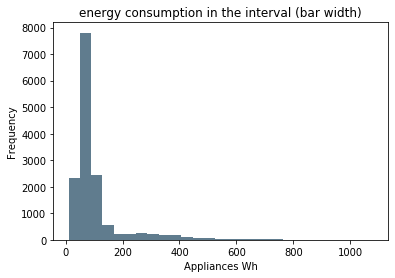

In [33]:
tr['Appliances'].plot.hist(color='#607c8e',rwidth=1,bins=27)
plt.title('energy consumption in the interval (bar width)')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')


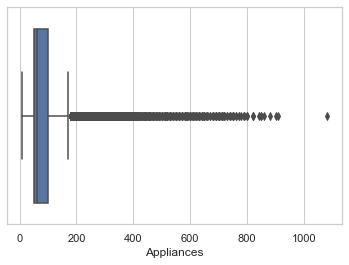

In [34]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=tr["Appliances"])

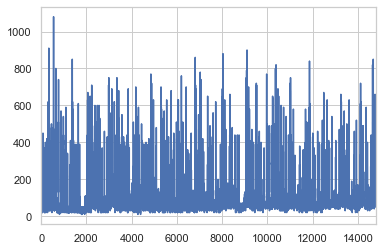

In [43]:
tr['Appliances'].plot()

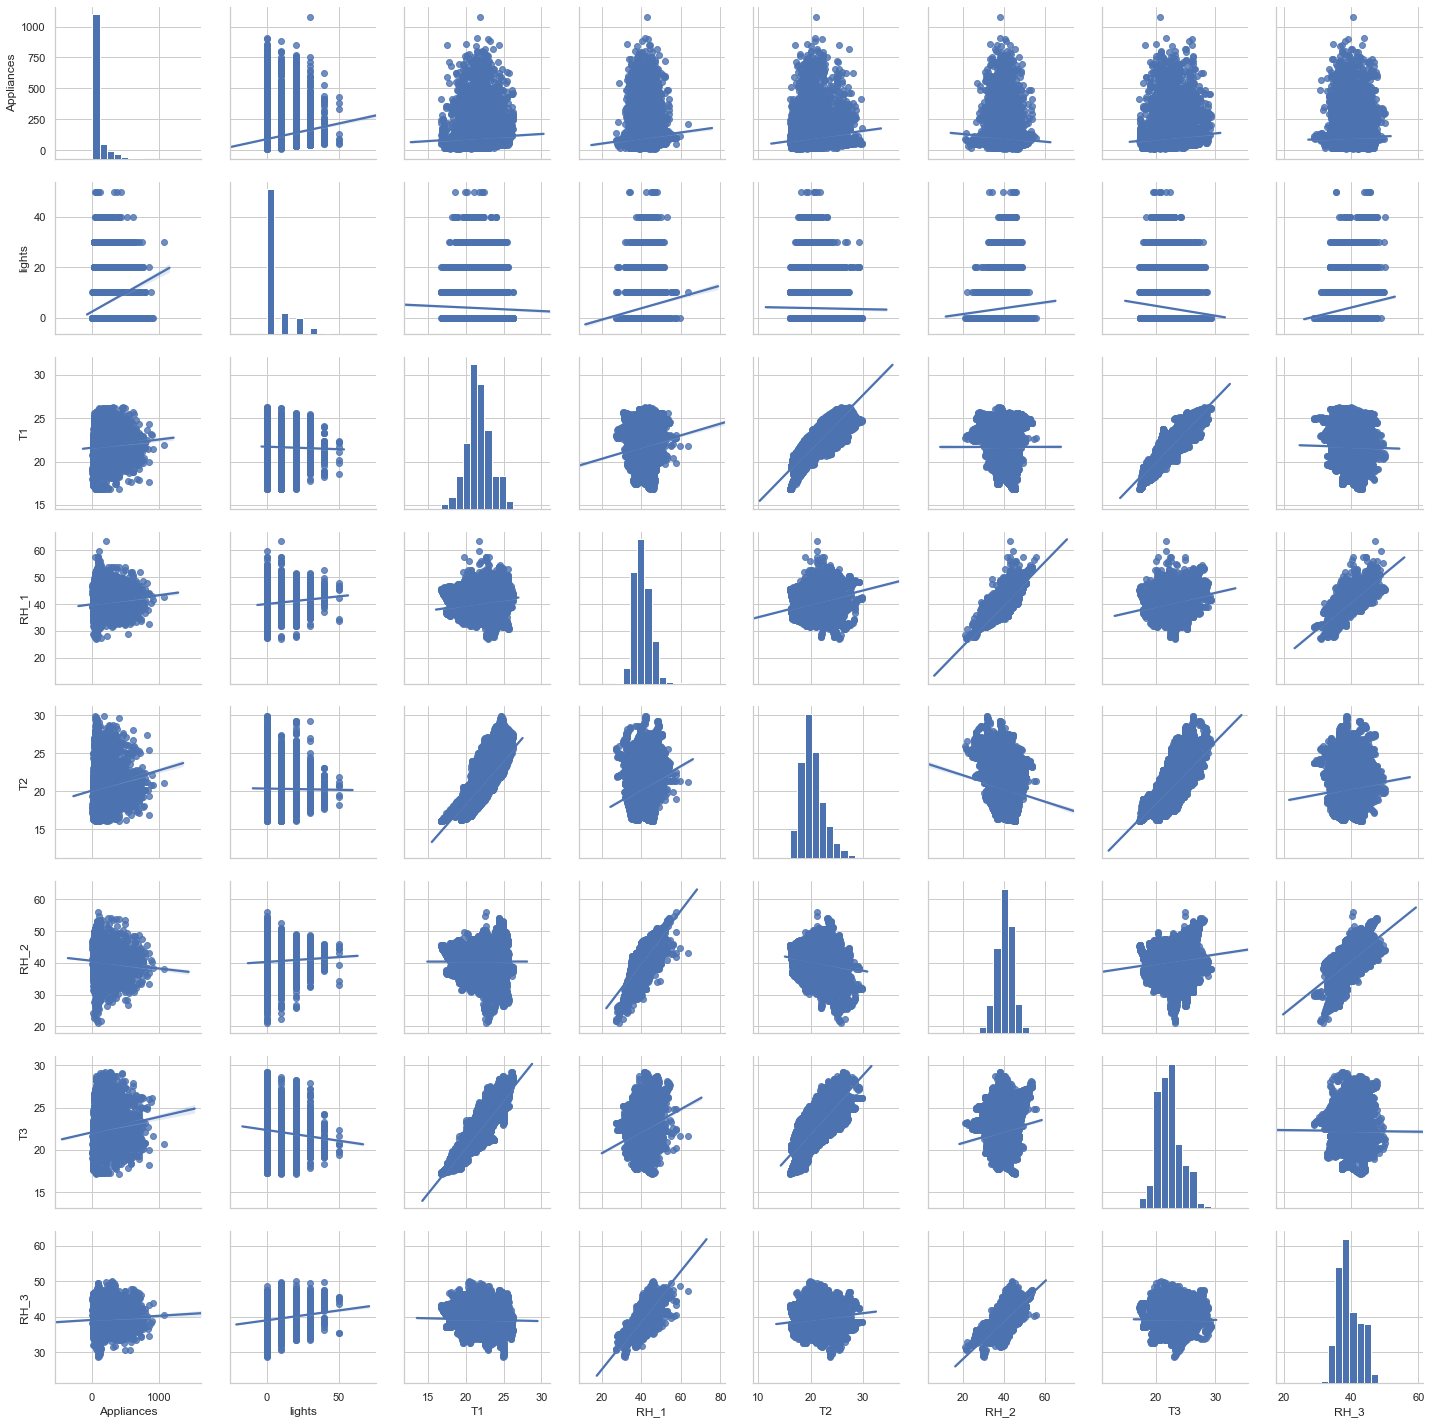

In [49]:
columns=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3']
df=tr[columns]
plot = sns.pairplot(df,kind="reg")

In [51]:
corr = df.corr()
corr

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3
Appliances,1.000000,0.194689,0.060137,0.087276,0.124719,-0.061108,0.093336,0.036765
lights,0.194689,1.000000,-0.028300,0.112602,-0.011521,0.059335,-0.099009,0.135162
T1,0.060137,-0.028300,1.000000,0.166716,0.837948,0.000574,0.892645,-0.026293
RH_1,0.087276,0.112602,0.166716,1.000000,0.273212,0.798149,0.257264,0.845261
T2,0.124719,-0.011521,0.837948,0.273212,1.000000,-0.160643,0.736325,0.123498
RH_2,-0.061108,0.059335,0.000574,0.798149,-0.160643,1.000000,0.141735,0.680792
T3,0.093336,-0.099009,0.892645,0.257264,0.736325,0.141735,1.000000,-0.007733
RH_3,0.036765,0.135162,-0.026293,0.845261,0.123498,0.680792,-0.007733,1.000000
